# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

[1. Изучение данных](#1)  
[2. Предобработка данных](#2)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Обработка пропусков](#2.1)   
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Замена типа данных](#2.2)   
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Обработка дубликатов](#2.3)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Лемматизация](#2.4)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.5 Категоризация данных](#2.5)  
[3. Ответы на вопросы](#3)  
[4. Общий вывод](#4)

## 1. Изучение данных

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mplt

import matplotlib.pyplot as plt
import seaborn as sns

from pymystem3 import Mystem
from collections import Counter
#df = pd.read_csv('/datasets/data.csv')
df = pd.read_csv('datasets/data.csv')
df.info()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


    С помощью метода describe() получим некоторую сводную информацию по всей таблице

In [5]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


**Вывод:** 
* Файл с даннными содержит таблицу из 12 колонок и 21525 строк
* В колонках *days_employed* и *total_income* есть пропущенные значения
* Ошибки в колонках *children* и *total_income*

## 2. Предобработка данных

### 2.1 Обработка пропусков

    Получаем перечень названий столбцов

In [6]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

    Переименуем некоторые столбцы для удобства восприятия:

In [7]:
#new_names = ['children_number', 'days_employed', 'full_age', 'education_level', 'education_id', 'family_status', 'family_status_id', 'gender', 'income_type', 'debt', 'total_income', 'purpose_loan']
#df.set_axis(new_names, axis = 'columns', inplace = True)
df.rename(columns={'children': 'children_number', 'dob_years': 'full_age', 
'education': 'education_level', 'purpose': 'purpose_loan'}, inplace=True)
df.head()

,children_number,days_employed,full_age,education_level,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose_loan
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


    Проверяем названия столбцов

In [8]:
df.columns

Index(['children_number', 'days_employed', 'full_age', 'education_level',
       'education_id', 'family_status', 'family_status_id', 'gender',
       'income_type', 'debt', 'total_income', 'purpose_loan'],
      dtype='object')

    Определим и заполним пропущенные значения:

In [9]:
df.isnull().sum()

children_number        0
days_employed       2174
full_age               0
education_level        0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose_loan           0
dtype: int64

    Количество пропусков одинаково в значениях days_employed и total_income, возможно проблема связана с выгрузкой данных из БД

    Пропуски по столбцам days_employed и total_income заполним медианным значениями методом .median():

In [10]:
df['days_employed'].fillna((df['days_employed'].median()), inplace=True)

In [11]:
df['total_income'].fillna((df['total_income'].median()), inplace=True)

    Прверим наличие пропущенных значений:

In [12]:
df.isnull().sum()

children_number     0
days_employed       0
full_age            0
education_level     0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose_loan        0
dtype: int64

**Вывод:** Выполнили переименование некоторых заголовков таблицы и заполнили пропуски медианными значениями.

### 2.2 Замена типа данных

    Определяем тип данных в талице:

In [13]:
df.dtypes

children_number       int64
days_employed       float64
full_age              int64
education_level      object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose_loan         object
dtype: object

    В столбцах days_employed и total_income видим вещественный (float64) тип данных. Проведем замену на целочисленный тип данных(int64):

    Заменяем вещественный тип данных на целочисленный в столбцах days_employed и total_income и производим проверку изменений:


In [14]:
#for columns in ['days_employed', 'total_income']:
#    df[columns] = df[columns].astype('int64')

df[['days_employed', 'total_income']] = df[['days_employed', 'total_income']].astype('int64')
df.dtypes

children_number      int64
days_employed        int64
full_age             int64
education_level     object
education_id         int64
family_status       object
family_status_id     int64
gender              object
income_type         object
debt                 int64
total_income         int64
purpose_loan        object
dtype: object

    Проверим значения в таблице на наличие аномалий:

In [15]:
df.head(10)

,children_number,days_employed,full_age,education_level,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose_loan
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,-5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,-926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,-2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,-152,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,-6929,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,-2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


    В колонке full_age есть ошибочное значение 0. Исправим на медианное и проверим:

In [16]:
df['full_age'].min()

0

In [17]:
df['full_age'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75], dtype=int64)

In [18]:
df['full_age'].median()

42.0

In [19]:
#df.loc[df['full_age'] == 0, 'full_age'] = 42# можно так
df['full_age'].replace([0], 42, inplace=True)# итак

df['full_age'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51, 59, 29, 60, 55, 58, 71, 22, 73, 66,
       69, 19, 72, 70, 74, 75], dtype=int64)

In [20]:
df['full_age'].min()

19

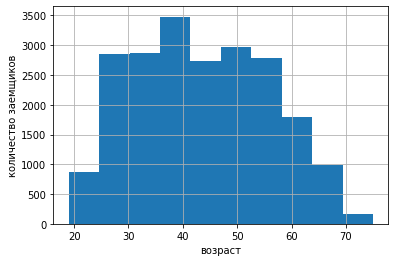

In [21]:
df.full_age.plot.hist();#проверим графически
plt.xlabel('возраст')
plt.ylabel("количество заемщиков")
plt.grid()
plt.show()

    В колонке days_employed и children_number смешанные значения (положительные и отрицательные), сделаем их положительными:

In [22]:
df['days_employed'] = df['days_employed'].abs()


In [23]:
df['children_number'] = df['children_number'].abs()

    Проверяем days_employed и children_number:

In [24]:
df['days_employed'].unique()

array([  8437,   4024,   5623, ..., 362161, 373995, 343937], dtype=int64)

In [25]:
df['children_number'].unique()

array([ 1,  0,  3,  2,  4, 20,  5], dtype=int64)

    20 детей - это явная ошибка, заменим значение на 2 и проверим:

In [26]:
df.loc[df['children_number'] == 20, 'children_number'] = 2
df['children_number'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

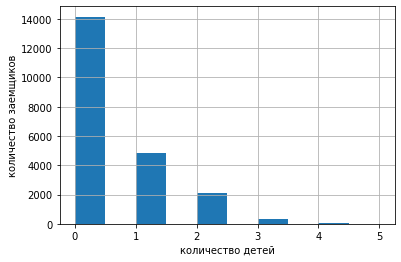

In [27]:
# Проверим графически. 
df.children_number.plot.hist();
plt.xlabel('количество детей')
plt.ylabel("количество заемщиков")
plt.grid()
plt.show()

    В колонке gender присутствует одно одно значение XNA:

In [28]:
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

    Меняем на произвольное.

In [29]:
df.loc[df['gender'] == 'XNA', 'gender'] = 'M'
df[df['gender'] == 'XNA']['gender'].count()

0

In [30]:
df['gender'].unique()

array(['F', 'M'], dtype=object)

**Вывод:** Проведенные изменения позволят выполнить дальнейшие расчеты.

### 2.3 Обработка дубликатов

    Проверим таблицу на наличие дубликатов:

In [31]:
df.duplicated().sum()

55

    Для дальнейшего удобства обработки данных, переведем названия колонок таблицы в нижний регистр методом str.lower()

In [32]:
df['education_level'] = df['education_level'].str.lower()

In [33]:
df['income_type'] = df['income_type'].str.lower()

In [34]:
df['purpose_loan'] = df['purpose_loan'].str.lower()

In [35]:
df['gender'] = df['gender'].str.lower()

In [36]:
df.head(10)

,children_number,days_employed,full_age,education_level,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose_loan
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,сыграть свадьбу
5,0,926,27,высшее,0,гражданский брак,1,m,компаньон,0,255763,покупка жилья
6,0,2879,43,высшее,0,женат / замужем,0,f,компаньон,0,240525,операции с жильем
7,0,152,50,среднее,1,женат / замужем,0,m,сотрудник,0,135823,образование
8,2,6929,35,высшее,0,гражданский брак,1,f,сотрудник,0,95856,на проведение свадьбы
9,0,2188,41,среднее,1,женат / замужем,0,m,сотрудник,0,144425,покупка жилья для семьи


    Проведем проверку таблицы на наличие дубликатов в данных:

In [37]:
df.duplicated().sum()

72

**Вывод:** Видим 72 дубля. Происхождение которых неясно. Избавимся от дублей и сбросив индексы данных.

In [38]:
df = df.drop_duplicates().reset_index(drop=True)

    Проверяем наличие дубликатов

In [39]:
df.duplicated().sum()

0

**Вывод:** В данных отсутствуют дубликаты, что позволянт провести достоверный анализ

### 2.4 Лемматизация

    Основная цель кредита - это преобретение материальных или нематериальных товаров. 
    Определим на какие цели берется кредит:

    Цели содержатся в столбеце purpose_loan. Сформируем уникальные цели по нему:

In [40]:
purpose_loan_unique = pd.DataFrame(df['purpose_loan'].unique(), columns = ['purpose_loan'])
purpose_loan_unique

,purpose_loan
0,покупка жилья
1,приобретение автомобиля
2,дополнительное образование
3,сыграть свадьбу
4,операции с жильем
5,образование
6,на проведение свадьбы
7,покупка жилья для семьи
8,покупка недвижимости
9,покупка коммерческой недвижимости


    Проведем лемматизацию по столбцу purpose_loan:

In [41]:
#m = Mystem()
#purpose_unique = df['purpose_loan'].unique()
#lemma = []
#for row in purpose_unique:
#    result = ''.join(m.lemmatize(row)).strip()
#    lemma.append(result)
#text = m.lemmatize(' '.join(lemma))
#lemma_cnt = Counter(text)
#print(lemma_cnt)


In [42]:
m = Mystem()
purpose_unique = m.lemmatize(' '.join(df['purpose_loan'].unique()))
lemma_cnt = Counter(purpose_unique)
print(lemma_cnt)

Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


    Определим количество целей

In [43]:
def purpose_loan_final(row):
    purpose_final = row['purpose_loan']
   
    if 'квартир' in purpose_final or 'дом' in purpose_final or 'недвиж' in purpose_final or 'жиль' in purpose_final:
        return 'недвижимость'
    elif 'авто' in purpose_final or 'машин' in purpose_final:
        return 'автомобиль'
    elif 'свадьб' in purpose_final:
        return 'свадьба'
    elif 'образ' in purpose_final:
        return 'образование'
    elif 'ремонт' in purpose_final:
            return 'ремонт'
    else:
        return purpose_final
    
df['lemm_purpose'] = df.apply(purpose_loan_final, axis=1)   
df['lemm_purpose'].value_counts()



недвижимость    10811
автомобиль       4306
образование      4013
свадьба          2323
Name: lemm_purpose, dtype: int64

**Вывод:** Лемматизация позволила определить основные цели кредита: **покупка жилья, покупка автомобиля, образование, свадьба**.

### 2.5 Категоризация данных

    Создадим таблицу с уникальными значениями и их количеством:

In [44]:
unique_cnt = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns], 
columns=['column_name', 'unique']).sort_values(by=['unique'])
unique_cnt # отобразим все уникальные значения из df и их количество

,column_name,unique
7,gender,2
9,debt,2
12,lemm_purpose,4
3,education_level,5
4,education_id,5
5,family_status,5
6,family_status_id,5
0,children_number,6
8,income_type,8
11,purpose_loan,38


Выделим **категориальные** данные: gender, education_level, education_id, family_status, family_status_id, income_type, purpose_loan

**Количественные:** children_number, full_age, days_employed, total_income

**Логические:** debt


    Значимые категории для расчета показателей: total_income, children_number, full_age

    Посчитаем медианный доход:

In [45]:
df['total_income'].median()

145017.0

    Ежемесячный доход распределим по категориям:

In [46]:
def category_total_income(row):
    if row <= 50000:
        return 'низкий доход до 50.000'
    
    if row <= 150000:
        return 'средний доход от 50.000 до 150.000'
    
    if row <= 300000:
        return 'высокий доход от 150.000 до 300.000'
    
    if row > 300000:
        return 'доход более 300.000'
    

    
df['category_total_income'] = df['total_income'].apply(category_total_income)
df['category_total_income'].value_counts()

средний доход от 50.000 до 150.000     11897
высокий доход от 150.000 до 300.000     7702
доход более 300.000                     1482
низкий доход до 50.000                   372
Name: category_total_income, dtype: int64


    Распределим количество детей по категориям:

In [47]:
print(df['children_number'].value_counts())

def category_children(row):
    if row == 0:
        return 'нет детей'
    elif row < 3:
        return 'обычная семья'
    else:
        return 'многодетная семья'
    
df['category_children'] = df['children_number'].apply(category_children)
df['category_children'].value_counts()

0    14090
1     4855
2     2128
3      330
4       41
5        9
Name: children_number, dtype: int64


нет детей            14090
обычная семья         6983
многодетная семья      380
Name: category_children, dtype: int64

    Распределим возраст заемщиков по категориям:

In [48]:
def category_full_age(row):
    if row <= 30:
        return 'молодой'
    
    if row <= 60:
        return 'средний возраст'
    
    if row > 60:
        return 'пенсионер'
    

    
df['category_full_age'] = df['full_age'].apply(category_full_age)
df['category_full_age'].value_counts()

средний возраст    15610
молодой             3717
пенсионер           2126
Name: category_full_age, dtype: int64

**Вывод:** Категоризация данных необходима для проведения оценки надежности заемщика 

## 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

    Для подготовки сводных таблиц используем метод pivot_table()

In [49]:
children_debt = df.pivot_table(index = 'children_number', values = 'debt', 
                            aggfunc = ['count', 'sum', 'mean', lambda x: 1 - x.mean()])
children_debt.columns = ['Кол-во заемщиков', 'Кол-во должников', '% должников', '% НЕдолжников']
children_debt.style.format({'% должников': '{:.2%}', '% НЕдолжников': '{:.2%}'})

,Кол-во заемщиков,Кол-во должников,% должников,% НЕдолжников
children_number,,,,
0,14090,1063,7.54%,92.46%
1,4855,445,9.17%,90.83%
2,2128,202,9.49%,90.51%
3,330,27,8.18%,91.82%
4,41,4,9.76%,90.24%
5,9,0,0.00%,100.00%


**Вывод** Из полученных результвтов следут, что чаще задолжность имеют люди с детьми

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

    Рассчитаем количество должников по каждой категории:

In [50]:
family_status_pivot = df.pivot_table(index = 'family_status', values = 'debt', 
                            aggfunc = ['count', 'sum', 'mean', lambda x: 1 - x.mean()])
family_status_pivot.columns = ['Кол-во заемщиков', 'Кол-во должников', '% должников', '% НЕдолжников']
family_status_pivot.style.format({'% должников': '{:.2%}', '% НЕдолжников': '{:.2%}'})

,Кол-во заемщиков,Кол-во должников,% должников,% НЕдолжников
family_status,,,,
Не женат / не замужем,2810,274,9.75%,90.25%
в разводе,1195,85,7.11%,92.89%
вдовец / вдова,959,63,6.57%,93.43%
гражданский брак,4150,388,9.35%,90.65%
женат / замужем,12339,931,7.55%,92.45%


**Вывод**: Больше всего должников находятся в статусе: Не женат / не замужем и гражданский брак.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

    Определим величину задолженности взависимости от величины дохода:

In [51]:
total_income_debt = df.pivot_table(index = 'category_total_income', values = 'debt', 
                            aggfunc = ['count', 'sum', 'mean', lambda x: 1 - x.mean()])
total_income_debt.columns = ['Кол-во пользователей', 'Кол-во должников', '% должников', '% НЕдолжников']
total_income_debt.style.format({'% должников': '{:.2%}', '% НЕдолжников': '{:.2%}'})

,Кол-во пользователей,Кол-во должников,% должников,% НЕдолжников
category_total_income,,,,
высокий доход от 150.000 до 300.000,7702,620,8.05%,91.95%
доход более 300.000,1482,106,7.15%,92.85%
низкий доход до 50.000,372,23,6.18%,93.82%
средний доход от 50.000 до 150.000,11897,992,8.34%,91.66%


**Вывод:** Чаще должниками становятся люди со средним доходом. Меньше вмего должников среди людей с низким доходом.

- Как разные цели кредита влияют на его возврат в срок?

In [52]:
lemm_purpose_debt = df.pivot_table(index = 'lemm_purpose', values = 'debt', 
                            aggfunc = ['count', 'sum', 'mean', lambda x: 1 - x.mean()])
lemm_purpose_debt.columns = ['Кол-во пользователей', 'Кол-во должников', '% должников', '% НЕдолжников']
lemm_purpose_debt.style.format({'% должников': '{:.2%}', '% НЕдолжников': '{:.2%}'})

,Кол-во пользователей,Кол-во должников,% должников,% НЕдолжников
lemm_purpose,,,,
автомобиль,4306,403,9.36%,90.64%
недвижимость,10811,782,7.23%,92.77%
образование,4013,370,9.22%,90.78%
свадьба,2323,186,8.01%,91.99%


**Вывод:** Максимальный процент должников по автокредитам. Меньше всех задолжали приобретатели недвижемости. 

## 4. Общий вывод

    Сформируем финальную информацию в виде графиков:

    Рассмотрим влияние количества детей на распределение признаков кредита:

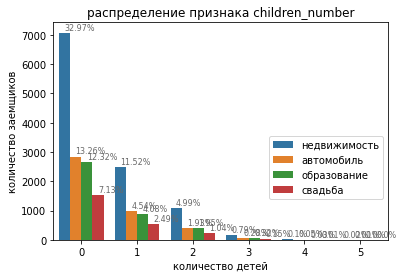

In [53]:
clients_discr_values = ['children_number']
fig, ax = plt.subplots()
for column in clients_discr_values:
    plt.title("распределение признака "+column)
    ax = sns.countplot(data=df, x=column, hue='lemm_purpose')
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()

#https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    totals = []
# find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())
        total = sum(totals)
    for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+.1, i.get_height()+99, \
                str(round((i.get_height()/total)*100, 2))+'%', fontsize=8,
                    color='dimgrey')

########################################################################
    for label in xlabels:
        label.set_rotation(0)# текст по х
    plt.xlabel('количество детей')
    plt.ylabel("количество заемщиков")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()



    Вывод: Чаще всего берут кредит люди без детей, особенно на недвижимость (32.97%).

    Расссомтрим влияние образования по категории кредита:

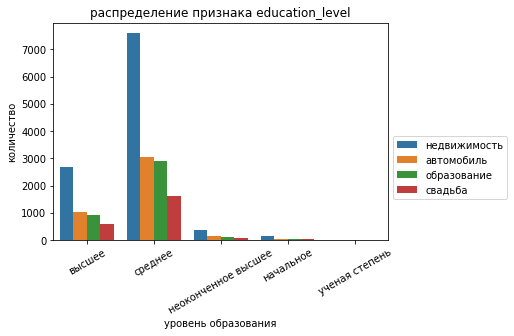

In [54]:
clients_discr_values = ['education_level']
fig, ax = plt.subplots()
for column in clients_discr_values:
    plt.title("распределение признака "+column)
    ax = sns.countplot(data=df, x=column, hue='lemm_purpose')
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()
    for label in xlabels:
        label.set_rotation(30)# текст по х
    plt.xlabel("уровень образования")
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()

    Вывод: Люди со средним образованием более чем в 2 раза чаще берут кредит относительно людей с высшим образованием.

    Рассмотрим влияние семейного статуса на категорию кредита

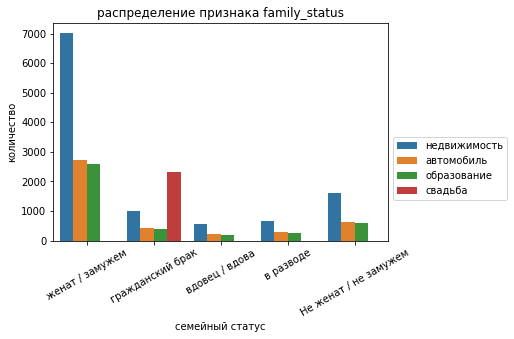

In [55]:
clients_discr_values = ['family_status']
fig, ax = plt.subplots()
for column in clients_discr_values:
    plt.title("распределение признака "+column)
    ax = sns.countplot(data=df, x=column, hue='lemm_purpose')
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()
    for label in xlabels:
        label.set_rotation(30)# текст по х
    plt.xlabel('семейный статус')
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()

    Вывод: чаще всего берут кредит заемщики состоящие в браке, особенно на недвижимость.

    Рассмотри влияяние пола на категорию кредита:

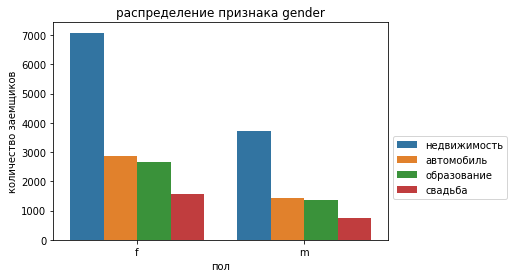

In [56]:
clients_discr_values = ['gender']
fig, ax = plt.subplots()
for column in clients_discr_values:
    plt.title("распределение признака "+column)
    ax = sns.countplot(data=df, x=column, hue='lemm_purpose')
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()
    for label in xlabels:
        label.set_rotation(0)# текст по х
    plt.xlabel("пол")
    plt.ylabel("количество заемщиков")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()

    Вывод: Женщины в 2 раза чаще берут кредит по всем категориям.

    Посмотрим на распределение долга по возрастным категориям:

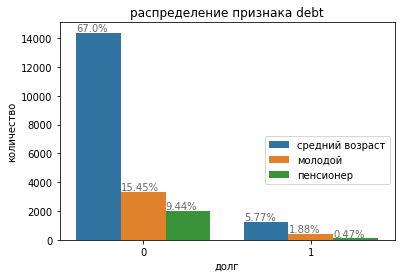

In [57]:
clients_discr_values = ['debt']#, 'total_income'
fig, ax = plt.subplots()
for column in clients_discr_values:
    plt.title("распределение признака "+column)
    ax = sns.countplot(data=df, x=column, hue='category_full_age')
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()

#https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    totals = []

# find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())
        total = sum(totals)
    for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+.0, i.get_height()+99, \
                str(round((i.get_height()/total)*100, 2))+'%', fontsize=10,
                    color='dimgrey')
########################################################################

    for label in xlabels:
        label.set_rotation(0)# текст по х
    plt.xlabel('долг')
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()

    Вывод: чаще всего имеют задолженность люди среднего возраста (67%).

    Рассмотрим влияние дохода на задолженность:

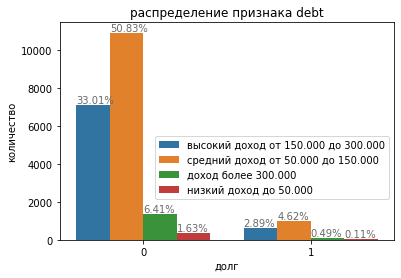

In [58]:
clients_discr_values = ['debt']#, 'total_income'
fig, ax = plt.subplots()
for column in clients_discr_values:
    plt.title("распределение признака "+column)
    ax = sns.countplot(data=df, x=column, hue='category_total_income')
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()

#https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    totals = []

# find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())
        total = sum(totals)
    for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+.0, i.get_height()+99, \
                str(round((i.get_height()/total)*100, 2))+'%', fontsize=10,
                    color='dimgrey')
########################################################################

    for label in xlabels:
        label.set_rotation(0)# текст по х
    plt.xlabel('долг')
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()

    Вывод:Чаще всего оказываются должниками люди со средним доходом (50.83%) и высоким (33.01%).

    Вывод: основными должниками являюся люди среднего возраста.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.